## Import Libraries
Loading all libraries to be used

In [2]:
import sys
# !{sys.executable} -m pip uninstall imblearn
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install wordcloud --user

In [3]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score
#from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data preparation
## Load data
Lets load the data from _dsjVoxArticles.tsv_ file. We will clean the title to remove special characters and punctuations. We will store title in _titles_ and Category in _categories_

In [4]:
categories = ['POLITICS','WELLNESS','ENTERTAINMENT','TRAVEL','STYLE & BEAUTY','PARENTING','HEALTHY LIVING','QUEER VOICES','FOOD & DRINK','BUSINESS','COMEDY','SPORTS','BLACK VOICES','HOME & LIVING','PARENTS','THE WORLDPOST','WEDDINGS','WOMEN','IMPACT','DIVORCE','CRIME','MEDIA','WEIRD NEWS','GREEN','WORLDPOST','RELIGION','STYLE','SCIENCE','WORLD NEWS','TASTE','TECH','MONEY','ARTS','FIFTY','GOOD NEWS','ARTS & CULTURE','ENVIRONMENT','COLLEGE','LATINO VOICES','CULTURE & ARTS','EDUCATION']

In [94]:
final_categories = ['POLITICS', 'DIVERSITY', 'LIFESTYLE & ENTERTAINMENT', 'BUSINESS & FINANCE', 'TRAVEL', 'SPORTS', 'CRIME','SCIENCE & TECH','ENVIRONMENT','ARTS & CULTURE','EDUCATION']

comb = dict()
comb["ENTERTAINMENT"] = "LIFESTYLE & ENTERTAINMENT"
# comb["WELLNESS"] = "LIFESTYLE & ENTERTAINMENT"
comb["STYLE & BEAUTY"] = "LIFESTYLE & ENTERTAINMENT"
# comb["PARENTING"] = "LIFESTYLE & ENTERTAINMENT"
# comb["HEALTHY LIVING"] = "LIFESTYLE & ENTERTAINMENT"
comb["QUEER VOICES"] = "DIVERSITY"
# comb["FOOD & DRINK"] = "LIFESTYLE & ENTERTAINMENT"
comb["BUSINESS"] = "BUSINESS & FINANCE"
comb["COMEDY"] = "LIFESTYLE & ENTERTAINMENT"
comb["BLACK VOICES"] = "DIVERSITY"
# comb["HOME & LIVING"] = "LIFESTYLE & ENTERTAINMENT"
# comb["PARENTS"] = "LIFESTYLE & ENTERTAINMENT"
comb["WEDDINGS"] = "LIFESTYLE & ENTERTAINMENT"
# comb["WOMEN"] = "DIVERSITY"
comb["IMPACT"] = "ENVIRONMENT"
comb["DIVORCE"] = "LIFESTYLE & ENTERTAINMENT"
comb["WEDDINGS"] = "LIFESTYLE & ENTERTAINMENT"
comb["GREEN"] = "ENVIRONMENT"
comb["RELIGION"] = "ARTS & CULTURE"
comb["STYLE"] = "LIFESTYLE & ENTERTAINMENT"
comb["SCIENCE"] = "SCIENCE & TECHNOLOGY"
comb["TASTE"] = "LIFESTYLE & ENTERTAINMENT"
comb["TECH"] = "SCIENCE & TECHNOLOGY"
comb["MONEY"] = "BUSINESS & FINANCE"
comb["ARTS"] = "ARTS & CULTURE"
comb["COLLEGE"] = "EDUCATION"
comb["LATINO VOICES"] = "DIVERSITY"
comb["CULTURE & ARTS"] = "ARTS & CULTURE"

dropped_categories = ["THE WORLDPOST", "MEDIA", "WORLDPOST", "WORLD NEWS", "FIFTY", "GOOD NEWS", "WELLNESS", "HEALTHY LIVING", "FOOD & DRINK", "PARENTING", "HOME & LIVING", "PARENTS", "WOMEN", "WEIRD NEWS"]
diff = [category for category in categories if category not in final_categories and category not in comb.keys()]
diff

[]

In [163]:
from collections import Counter

def clean_title(title):
    title = title.lower()
    title = re.sub('\s\W',' ',title)
    title = re.sub('\W\s',' ',title)
    return title



data = pd.read_csv('cleaned.csv')
category_counter = Counter(data["category"])
# with open('dsjVoxArticles.csv','r') as tsv:
# with open('cleaned.csv','rb') as csv:
#     prev1, prev2 = None, None
#     count = 0;
#     for line in csv:
#         tokens = line.decode('utf-8').strip().split(',')[:3]
#         count += 1
#         prev2 = prev1
#         prev1 = tokens
# #         print(tokens)
#         if len(tokens) != 3:
#             print(prev2, prev1, tokens)
#             continue
# #         assert len(tokens) == 3, str(tokens)
#         category_counter[tokens[1]] += 1
# #         if tokens[2] in ['Business & Finance', 'Health Care', 'Science & Health', 'Politics & Policy', 'Criminal Justice']:
# #             titles.append(clean_title(a[0].lower()))
# #             categories.append(a[2])
print(category_counter.most_common(100))
print(len(data))
data.head()

[('POLITICS', 32630), ('WELLNESS', 17825), ('ENTERTAINMENT', 16004), ('TRAVEL', 9855), ('STYLE & BEAUTY', 9648), ('PARENTING', 8677), ('HEALTHY LIVING', 6568), ('QUEER VOICES', 6303), ('FOOD & DRINK', 6224), ('WORLDPOST', 6192), ('BUSINESS', 5898), ('COMEDY', 5022), ('SPORTS', 4845), ('BLACK VOICES', 4516), ('HOME & LIVING', 4193), ('PARENTS', 3948), ('WEDDINGS', 3651), ('WOMEN', 3467), ('IMPACT', 3438), ('DIVORCE', 3426), ('CRIME', 3390), ('MEDIA', 2792), ('WEIRD NEWS', 2648), ('GREEN', 2605), ('RELIGION', 2501), ('STYLE', 2242), ('WORLD NEWS', 2177), ('SCIENCE', 2173), ('TECH', 2080), ('TASTE', 2075), ('MONEY', 1707), ('ARTS', 1480), ('GOOD NEWS', 1385), ('FIFTY', 1381), ('ARTS & CULTURE', 1339), ('ENVIRONMENT', 1323), ('COLLEGE', 1139), ('LATINO VOICES', 1127), ('CULTURE & ARTS', 1029), ('EDUCATION', 991)]
199914


,Unnamed: 0,category,text
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [166]:
# Sample headlines of a category
data[data["category"] == "WORLD NEWS"]

,Unnamed: 0,category,text
11,11,WORLD NEWS,South Korean President Meets North Korea's Kim...
23,23,WORLD NEWS,North Korea Still Open To Talks After Trump Ca...
24,24,WORLD NEWS,2 Men Detonate Bomb Inside Indian Restaurant N...
25,25,WORLD NEWS,Thousands Travel Home To Ireland To Vote On Ab...
26,26,WORLD NEWS,Irish Voters Set To Liberalize Abortion Laws I...
...,...,...,...
26027,26030,WORLD NEWS,The Riyadh Summits: A Workshop For A Global Fr...
26036,26039,WORLD NEWS,Donald Of Arabia If Trump continues on this pa...
26044,26047,WORLD NEWS,Resistance Grows Against Hungarian Government'...
26106,26109,WORLD NEWS,Trump’s Counter-Extremism Effort Should Addres...


In [96]:
# Drop categories
for drop in dropped_categories:
    data.drop(data[data.category == drop].index, inplace=True)

# Apply Map 
data["new_category"] = data.apply(lambda row: comb[row.category] if row.category in comb.keys() else row.category, axis=1)
category_counter = Counter(data["new_category"])
print(category_counter.most_common(100))
print(len(data))
data.head()

[('LIFESTYLE & ENTERTAINMENT', 42068), ('POLITICS', 32630), ('DIVERSITY', 11946), ('TRAVEL', 9855), ('BUSINESS & FINANCE', 7605), ('ENVIRONMENT', 7366), ('ARTS & CULTURE', 6349), ('SPORTS', 4845), ('SCIENCE & TECHNOLOGY', 4253), ('CRIME', 3390), ('EDUCATION', 2130)]
132437


,Unnamed: 0,category,text,new_category
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,LIFESTYLE & ENTERTAINMENT
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,LIFESTYLE & ENTERTAINMENT
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,LIFESTYLE & ENTERTAINMENT
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,LIFESTYLE & ENTERTAINMENT


We can print and check the data loaded in _titles_ and _categories_

## Split data
Split data into 3 parts - training, development and test. We will use training data to train out model and use development data to check and tune hyper parameters. And finally use test data to see how our model performs

In [114]:
data = data.sample(frac=1)

# Subset
subset = None#10000
if subset:
    title_tr, title_te, category_tr, category_te = train_test_split(data.text[:subset].to_numpy(), data.new_category[:subset].to_numpy())
    title_tr, title_de, category_tr, category_de = train_test_split(title_tr, category_tr)
else:
    title_tr, title_te, category_tr, category_te = train_test_split(data.text.to_numpy(), data.new_category.to_numpy())
    title_tr, title_de, category_tr, category_de = train_test_split(title_tr, category_tr)
print("Training: ",len(title_tr))
print("Development: ",len(title_de),)
print("Testing: ",len(title_te))

Training:  74495
Development:  24832
Testing:  33110


Using wordCload we can visualize our data.

In [115]:
from wordcloud import WordCloud
viz = False
if viz:
    text = " ".join(title_tr)
    wordcloud = WordCloud().generate(text)
    plt.figure()
    plt.subplots(figsize=(20,12))
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40,
        relative_scaling=.5).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# Data Preprocessing
## Vectorization of data
Vectorize the data using Bag of words (BOW)

In [116]:
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
stop_words = nltk.corpus.stopwords.words("english")
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)

vectorizer.fit(iter(title_tr))
Xtr = vectorizer.transform(iter(title_tr))
Xde = vectorizer.transform(iter(title_de))
Xte = vectorizer.transform(iter(title_te))

encoder = LabelEncoder()
encoder.fit(category_tr)
Ytr = encoder.transform(category_tr)
Yde = encoder.transform(category_de)
Yte = encoder.transform(category_te)

C:\Users\Stefa\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Lets look at what exactly is this vectorizer doing. We will first create reverse dictionary from the vectorizer. Iterating over the vectorized sentence _Nasa scientists are good_. We get the vector to be representative of three words "good", "nasa" and "scientists". The order has been changed because bag of words does not preserve order.

In [117]:
reverse_vocabulary = {}
vocabulary = vectorizer.vocabulary_
for word in vocabulary:
    index = vocabulary[word]
    reverse_vocabulary[index] = word

vector = vectorizer.transform(iter(['Nasa scientists are good']))
indexes = vector.indices
for i in indexes:
    print (reverse_vocabulary[i])

good
nasa
scientists


## Feature Reduction
We can check the variance of the feature and drop them based on a threshold

In [118]:
print("Number of features before reduction : ", Xtr.shape[1])
selection = VarianceThreshold(threshold=0.001)
Xtr_whole = copy.deepcopy(Xtr)
Ytr_whole = copy.deepcopy(Ytr)
selection.fit(Xtr)
Xtr = selection.transform(Xtr)
Xde = selection.transform(Xde)
Xte = selection.transform(Xte)
print("Number of features after reduction : ", Xtr.shape[1])

Number of features before reduction :  56866
Number of features after reduction :  3558


## Sampling data
We will count the number of diffrent labels in dataset and plot a pie chart distribution.

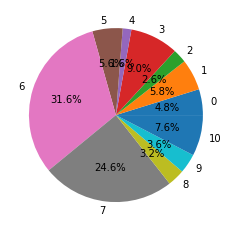

In [119]:
labels = list(set(Ytr))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Ytr == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

As we can see the class labels are not uniformy distributed so we will use SMOT and oversample the classes which are less in number so that classes are equally distributed

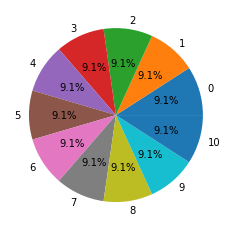

In [120]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
Xtr, Ytr = sm.fit_resample(Xtr, Ytr)
labels = list(set(Ytr))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Ytr == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

# Train Models
### Baseline Model
“stratified”: generates predictions by respecting the training set’s class distribution.

In [90]:
dc = DummyClassifier(strategy="stratified")
dc.fit(Xtr, Ytr)
pred = dc.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                           precision    recall  f1-score   support

           ARTS & CULTURE       0.06      0.13      0.08        77
       BUSINESS & FINANCE       0.05      0.08      0.06        93
                    CRIME       0.05      0.16      0.08        55
                DIVERSITY       0.09      0.08      0.08       168
                EDUCATION       0.02      0.15      0.04        26
              ENVIRONMENT       0.10      0.16      0.12        95
LIFESTYLE & ENTERTAINMENT       0.27      0.08      0.12       586
                 POLITICS       0.25      0.08      0.12       464
     SCIENCE & TECHNOLOGY       0.04      0.12      0.06        51
                   SPORTS       0.01      0.02      0.02        81
                   TRAVEL       0.11      0.12      0.12       144
               WEIRD NEWS       0.01      0.06      0.02        35

                 accuracy                           0.09      1875
                macro avg       0.09      0.10      0.08    

### Multinomial Naive Bayesian

In [121]:
nb = MultinomialNB()
nb.fit(Xtr, Ytr)
pred = nb.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                           precision    recall  f1-score   support

           ARTS & CULTURE       0.48      0.49      0.48      1224
       BUSINESS & FINANCE       0.49      0.64      0.56      1379
                    CRIME       0.48      0.73      0.58       609
                DIVERSITY       0.55      0.58      0.56      2258
                EDUCATION       0.43      0.49      0.46       383
              ENVIRONMENT       0.45      0.57      0.50      1336
LIFESTYLE & ENTERTAINMENT       0.86      0.71      0.78      7970
                 POLITICS       0.82      0.76      0.79      6167
     SCIENCE & TECHNOLOGY       0.52      0.46      0.49       803
                   SPORTS       0.56      0.69      0.62       891
                   TRAVEL       0.65      0.80      0.72      1812

                 accuracy                           0.68     24832
                macro avg       0.57      0.63      0.59     24832
             weighted avg       0.71      0.68      0.69    

# Final Model: Multinomial Naive Bayesian
**Multinomial Naive Bayesian** works the best. Lets run NB on our test data and get the confusion matrix and its heat map.
## Predict test data

                           precision    recall  f1-score   support

           ARTS & CULTURE       0.45      0.49      0.47      1545
       BUSINESS & FINANCE       0.52      0.63      0.57      1915
                    CRIME       0.48      0.69      0.56       861
                DIVERSITY       0.53      0.57      0.55      3005
                EDUCATION       0.47      0.53      0.50       546
              ENVIRONMENT       0.44      0.56      0.49      1847
LIFESTYLE & ENTERTAINMENT       0.85      0.71      0.77     10569
                 POLITICS       0.83      0.76      0.79      8120
     SCIENCE & TECHNOLOGY       0.47      0.47      0.47      1074
                   SPORTS       0.62      0.66      0.64      1255
                   TRAVEL       0.64      0.80      0.71      2373

                 accuracy                           0.68     33110
                macro avg       0.57      0.63      0.59     33110
             weighted avg       0.70      0.68      0.69    

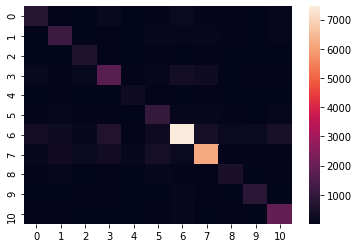

In [122]:
pred = nb.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))
sns.heatmap(confusion_matrix(Yte, pred))

In [174]:
import pickle

# save the model to disk
model_file, vectorizer_file, selection_file, encoder_file = 'model.pkl', 'vectorizer.pkl', 'selection.pkl', 'encoder.pkl'
pickle.dump(nb, open(model_file, 'wb'))
pickle.dump(vectorizer, open(vectorizer_file, 'wb'))
pickle.dump(selection, open(selection_file, 'wb'))
pickle.dump(encoder, open(encoder_file, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(model_file, 'rb'))
vectorizer = pickle.load(open(vectorizer_file, 'rb'))
selection_file = pickle.load(open(selection_file, 'rb'))
encoder_file = pickle.load(open(encoder_file, 'rb'))
result = loaded_model.score(Xte, Yte)
print(result)

0.6787073391724554


## Multinomial Naive Bayesian Explained
We will now try to understand why Naive Bayesian is getting good results. We will get all the coefficents of the features and then print the top 20 words based on its weight. As we can see all the words are closely related to the category, hence multinomial naive bayesian predcits correct label with good F1 score.

In [113]:
nb1 = MultinomialNB()
nb1.fit(Xtr_whole, Ytr_whole)
coefs = nb1.coef_
target_names = encoder.classes_

for i in range(len(target_names)):
    words = []
    for j in coefs[i].argsort()[-20:]:
        words.append(reverse_vocabulary[j])
    print (target_names[i], '-', words, "\n")

ARTS & CULTURE - ['could', 'may', 'book', 'daily', 'made', 'religious', 'artist', 'something', 'life', 'us', 'first', 'pope', 'day', 'women', 'people', 'world', 'god', 'one', 'new', 'art'] 

BUSINESS & FINANCE - ['like', 'would', 'year', 'world', '7', 'pay', 'bank', 'financial', 'company', 'tax', 'many', 'years', 'wall', 'money', 'new', 'people', 'women', 'time', 'credit', 'business'] 

CRIME - ['one', 'video', 'people', 'woman', 'found', 'arrested', 'killed', 'cops', 'death', 'officer', 'new', 'say', 'said', 'accused', 'shooting', 'year', 'old', 'allegedly', 'man', 'police'] 

DIVERSITY - ['many', 'get', 'family', 'men', 'week', 'first', 'us', 'lgbtq', 'love', 'community', 'life', 'like', 'said', 'lgbt', 'year', 'one', 'people', 'new', 'black', 'gay'] 

EDUCATION - ['get', 'today', 'parents', 'debt', 'good', 'loans', 'president', 'high', 'schools', 'peer', 'one', 'charter', 'like', 'teachers', 'new', 'students', 'student', 'education', 'school', 'college'] 

ENVIRONMENT - ['week', 'ta

C:\Users\Stefa\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [175]:
def categorize(model, vectorizer, selection, encoder, input_iterable):
    text_input = np.array(input_iterable)
    X = vectorizer.transform(iter(test_input))
    X = selection.transform(X)
    pred = model.predict(X)
    return encoder.inverse_transform(pred)

input_test = ["Engine parts from 777 fall over Denver, bringing more woes for United"]
res = categorize(nb, vectorizer, selection, encoder, input_test)
zipped = zip(input_test, res)
for pair in zipped:
    print(pair)

('Engine parts from 777 fall over Denver, bringing more woes for United', 'SCIENCE & TECHNOLOGY')


In [14]:
# import copy
import numpy as np
# import matplotlib.pyplot as plt
# import re
# import nltk
# nltk.download('stopwords')
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_selection import VarianceThreshold
# import imblearn
# from imblearn.over_sampling import SMOTE
# from sklearn.dummy import DummyClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import RandomForestClassifier
# #from sklearn.metrics import accuracy_score
# #from sklearn.model_selection import cross_val_score, KFold
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# import seaborn as sns
# import pandas as pd
import pickle

class NewsClassifier:
    def __init__(self, model_path='model.pkl', vectorizer_path='vectorizer.pkl', selection_path='selection.pkl', encoder_path='encoder.pkl'):
        self.model_path = model_path
        self.vectorizer_path = vectorizer_path
        self.selection_path = selection_path
        self.encoder_path = encoder_path
        
    def update_paths(self, model_path=None, vectorizer_path=None, selection_path=None, encoder_path=None):
        if model_path:
            self.model_path = model_path
        if vectorizer_path:
            self.vectorizer_path = vectorizer_path
        if selection_path:
            self.selection_path = selection_path
        if encoder_path:
            self.encoder_path = encoder_path
    
    def load(self):
        self.model = pickle.load(open(self.model_path, 'rb'))
        self.vectorizer = pickle.load(open(self.vectorizer_path, 'rb'))
        self.selection = pickle.load(open(self.selection_path, 'rb'))
        self.encoder = pickle.load(open(self.encoder_path, 'rb'))
        
    def save(self):
        pickle.dump(self.model, open(self.model_path, 'wb'))
        pickle.dump(self.vectorizer, open(vectorizer_path, 'wb'))
        pickle.dump(self.selection, open(selection_path, 'wb'))
        pickle.dump(self.encoder, open(encoder_path, 'wb'))
    
    def predict(self, input_iterable):
        X = self.vectorizer.transform(iter(np.array(input_iterable)))
        X = self.selection.transform(X)
        pred = self.model.predict(X)
        return self.encoder.inverse_transform(pred)

In [7]:
model_file, vectorizer_file, selection_file, encoder_file = 'model.pkl', 'vectorizer.pkl', 'selection.pkl', 'encoder.pkl'

# load the model from disk
loaded_model = pickle.load(open(model_file, 'rb'))
vectorizer = pickle.load(open(vectorizer_file, 'rb'))
selection = pickle.load(open(selection_file, 'rb'))
encoder = pickle.load(open(encoder_file, 'rb'))

def categorize(model, vectorizer, selection, encoder, input_iterable):
    


In [15]:
classifier = NewsClassifier()
classifier.load()
input_test = ["Salad's covid relief bill passes the house and heads on to the senate", "Notorious pirate Tristan brown apprehended by police on tuesday morning", "top scientist neil griffith discovers cure for cancer", "Stefan leads the LA lakers with 40 points to win the NBA finals"]
res = classifier.predict(input_test)

# res = categorize(loaded_model, vectorizer, selection, encoder, input_test)
zipped = zip(input_test, res)
for pair in zipped:
    print(pair)

("Salad's covid relief bill passes the house and heads on to the senate", 'POLITICS')
('Notorious pirate Tristan brown apprehended by police on tuesday morning', 'CRIME')
('top scientist neil griffith discovers cure for cancer', 'SCIENCE & TECHNOLOGY')
('Stefan leads the LA lakers with 40 points to win the NBA finals', 'SPORTS')
